In [153]:
!pip install xgboost

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [155]:
df = pd.read_csv('/content/python machine learning model xgboost - electricity demand dataset.csv')

In [156]:
df.shape

(43848, 9)

In [157]:
df.head()

,Timestamp,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
0,01-Jan-20,0.0,2.0,1.0,2020.0,1.0,3.000000,61.288951,2457.119872
1,01-Jan-20,1.0,2.0,1.0,2020.0,1.0,3.000000,52.873702,2269.904712
2,01-Jan-20,2.0,2.0,1.0,2020.0,1.0,4.244482,36.341783,2215.640403
3,01-Jan-20,3.0,2.0,1.0,2020.0,1.0,3.000000,72.629378,2174.232413
4,01-Jan-20,4.0,2.0,1.0,2020.0,1.0,3.881208,90.582444,2472.453006


In [158]:
df.tail()

,Timestamp,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
43843,31-Dec-24,19.0,1.0,12.0,2024.0,366.0,3.956838,43.287161,4689.693109
43844,31-Dec-24,20.0,1.0,12.0,2024.0,366.0,3.118824,51.705756,4331.249224
43845,31-Dec-24,21.0,1.0,12.0,2024.0,366.0,3.000000,40.565916,4015.979957
43846,31-Dec-24,22.0,1.0,12.0,2024.0,366.0,3.000000,51.998107,3353.241682
43847,31-Dec-24,23.0,1.0,12.0,2024.0,366.0,6.037472,59.931925,3219.023339


In [159]:
print(f'number of duplicates in data is:',df.duplicated().sum())

number of duplicates in data is: 3


In [160]:
df = df.drop_duplicates()

In [161]:
df.isna().sum()

,0
Timestamp,0
hour,8
dayofweek,6
month,5
year,2
dayofyear,2
Temperature,4
Humidity,7
Demand,4


In [162]:
df.dtypes

,0
Timestamp,object
hour,float64
dayofweek,float64
month,float64
year,float64
dayofyear,float64
Temperature,float64
Humidity,float64
Demand,float64


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43845 entries, 0 to 43847
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    43845 non-null  object 
 1   hour         43837 non-null  float64
 2   dayofweek    43839 non-null  float64
 3   month        43840 non-null  float64
 4   year         43843 non-null  float64
 5   dayofyear    43843 non-null  float64
 6   Temperature  43841 non-null  float64
 7   Humidity     43838 non-null  float64
 8   Demand       43841 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.3+ MB


In [164]:
# converting timestamp dtype to pd datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [165]:
df = df.set_index('Timestamp')

In [166]:
df.head()

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2020-01-01,0.0,2.0,1.0,2020.0,1.0,3.000000,61.288951,2457.119872
2020-01-01,1.0,2.0,1.0,2020.0,1.0,3.000000,52.873702,2269.904712
2020-01-01,2.0,2.0,1.0,2020.0,1.0,4.244482,36.341783,2215.640403
2020-01-01,3.0,2.0,1.0,2020.0,1.0,3.000000,72.629378,2174.232413
2020-01-01,4.0,2.0,1.0,2020.0,1.0,3.881208,90.582444,2472.453006


In [167]:
df[['Temperature','Humidity','Demand']].describe()

,Temperature,Humidity,Demand
count,43841.000000,43838.000000,43841.000000
mean,25.067788,59.903007,5000.790976
std,12.821725,18.342604,1412.527409
min,3.000000,20.000000,1611.954020
25%,15.210186,46.241224,4015.668472
50%,25.003212,59.986720,5013.053367
75%,34.740971,73.796820,6000.803082
max,50.000000,95.000000,11910.705100


In [168]:
# here we are viewing each data point in which values are nan
df[df.isna().any(axis=1)]

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2020-04-30,NaN,3.0,4.0,2020.0,121.0,21.820261,41.353675,5393.127681
2020-07-21,NaN,1.0,7.0,2020.0,203.0,36.555833,62.779665,6248.349423
2021-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-27,NaN,5.0,2.0,2021.0,58.0,24.001003,53.303268,4523.253789
2021-12-13,23.0,0.0,12.0,2021.0,NaN,3.000000,75.457130,3225.225822
2021-12-14,NaN,1.0,12.0,2021.0,348.0,5.061319,47.215825,2887.848612
2021-12-14,14.0,1.0,12.0,2021.0,348.0,15.403995,74.011557,NaN
2022-06-17,13.0,4.0,6.0,2022.0,168.0,NaN,43.171391,7196.200962
2022-06-17,NaN,4.0,6.0,2022.0,168.0,42.924693,43.645711,7605.572464


In [169]:
df[df.isna().all(axis=1)]

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2021-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


this data point does not contain any value all are nan so it does not make sense to impute this we will drop this datapoint

In [170]:
# drop row in which all values are missing
df = df.dropna(how='all')

In [171]:
df.isna().sum()

,0
hour,7
dayofweek,5
month,4
year,1
dayofyear,1
Temperature,3
Humidity,6
Demand,3


to fill this missing value we have three techniques forward fill, backward fill and interpolation

we will use forward fill for 'hours',  'dayofweek', 'month', 'year', 'dayofyear'

backward fill for 'temperature' and 'humidity' columns

and interpolation for 'demand' columns

In [172]:
df[['hour','dayofweek','month','year','dayofyear']] = df[['hour','dayofweek','month','year','dayofyear']].ffill()
df[['Temperature','Humidity']] = df[['Temperature','Humidity']].bfill()
df['Demand'] = df['Demand'].interpolate(method = 'time')

In [173]:
df.isna().sum()

,0
hour,0
dayofweek,0
month,0
year,0
dayofyear,0
Temperature,0
Humidity,0
Demand,0


we cannot feed 'timestamp' columns directely to ML model we have to create some usefull features from 'timestamp' columns.

Like quarter of year, week of year and weekand

**Feature enginerring**

In [174]:
df.head()

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2020-01-01,0.0,2.0,1.0,2020.0,1.0,3.000000,61.288951,2457.119872
2020-01-01,1.0,2.0,1.0,2020.0,1.0,3.000000,52.873702,2269.904712
2020-01-01,2.0,2.0,1.0,2020.0,1.0,4.244482,36.341783,2215.640403
2020-01-01,3.0,2.0,1.0,2020.0,1.0,3.000000,72.629378,2174.232413
2020-01-01,4.0,2.0,1.0,2020.0,1.0,3.881208,90.582444,2472.453006





we have to create some columns to make feature more meaningfull

In [175]:
df.insert(5,'quarter',df.index.quarter)

In [176]:
# convert float dtypes to int
df[['hour','dayofweek','month','dayofyear']] = df[['hour','dayofweek','month','dayofyear']].astype(int)

In [177]:
# here we create week of year feature this give info like which week of year this is
df.insert(5,'weekofyear',df.index.isocalendar().week.astype(int))

In [178]:
# here we create weekend column and pass 5,6 value to know that this is saturady or sunday
df.insert(7,'weekend',df.index.dayofweek.isin([5,6]).astype(int))

Lagged features are a powefull technique in time series modeling they represent past values of a variable as new features basically heping a model to remember the past like the value of today might depend on the value yesterday or last week.

In [179]:
#here we are creating a 'demand_24_' means past 24 hours demand
df['demand_24'] = df['Demand'].shift(24)

In [180]:
df['demand_168'] = df['Demand'].shift(168)  #24*7 = 168 hours weekly shift

In [181]:
# now we create two columns one is rolling mean and rolling std of demand

## it will detect trend and smotthen noise in data
df['demand_rol_mean_24'] = df['Demand'].rolling(window=24).mean()
df['demand_rol_std_24'] = df['Demand'].rolling(window=24).std()

In [182]:
df = df.dropna()

In [183]:
df.head()

,hour,dayofweek,month,year,dayofyear,weekofyear,quarter,weekend,Temperature,Humidity,Demand,demand_24,demand_168,demand_rol_mean_24,demand_rol_std_24
Timestamp,,,,,,,,,,,,,,,
2020-01-08,0,2,1,2020.0,8,2,1,0,3.000000,47.891592,2363.060115,2216.875986,2457.119872,3857.890516,1007.130968
2020-01-08,1,2,1,2020.0,8,2,1,0,4.433666,61.209727,2282.558766,2400.102433,2269.904712,3852.992863,1014.785101
2020-01-08,2,2,1,2020.0,8,2,1,0,5.000529,63.868618,2193.324174,2493.107375,2215.640403,3840.501897,1033.916351
2020-01-08,3,2,1,2020.0,8,2,1,0,4.253477,44.603210,2208.724679,2241.451559,2174.232413,3839.138277,1036.136212
2020-01-08,4,2,1,2020.0,8,2,1,0,5.966044,85.921008,2402.611018,2406.161001,2472.453006,3838.990361,1036.349905


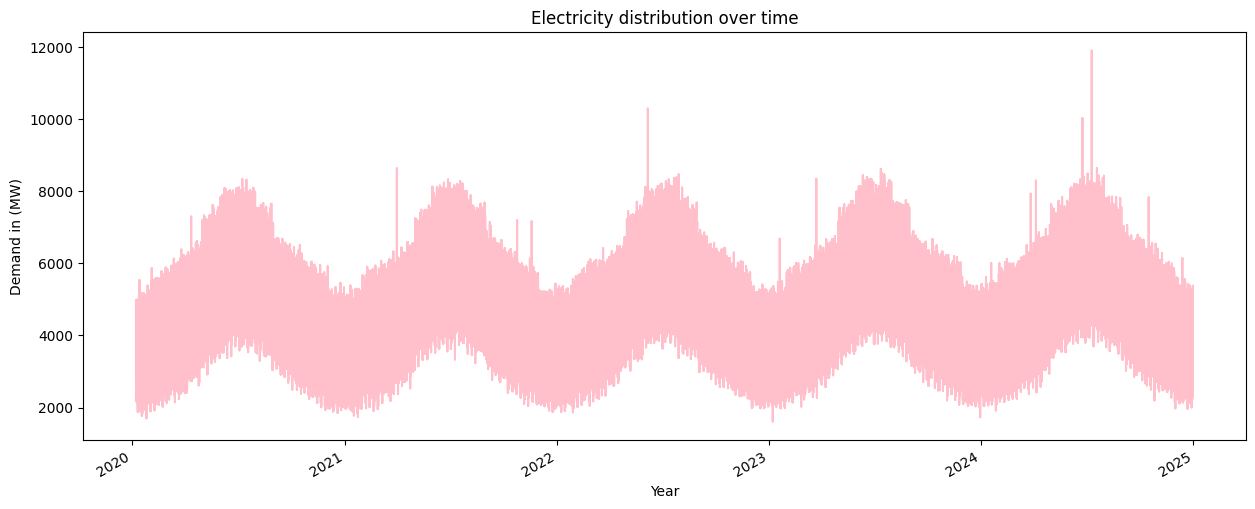

In [184]:
df['Demand'].plot(figsize=(15,6),title='Electricity distribution over time',color='pink')
plt.xlabel('Year')
plt.ylabel('Demand in (MW)')
plt.show()

* as we can see the demand of electricity decrease in winter
and increases in summer

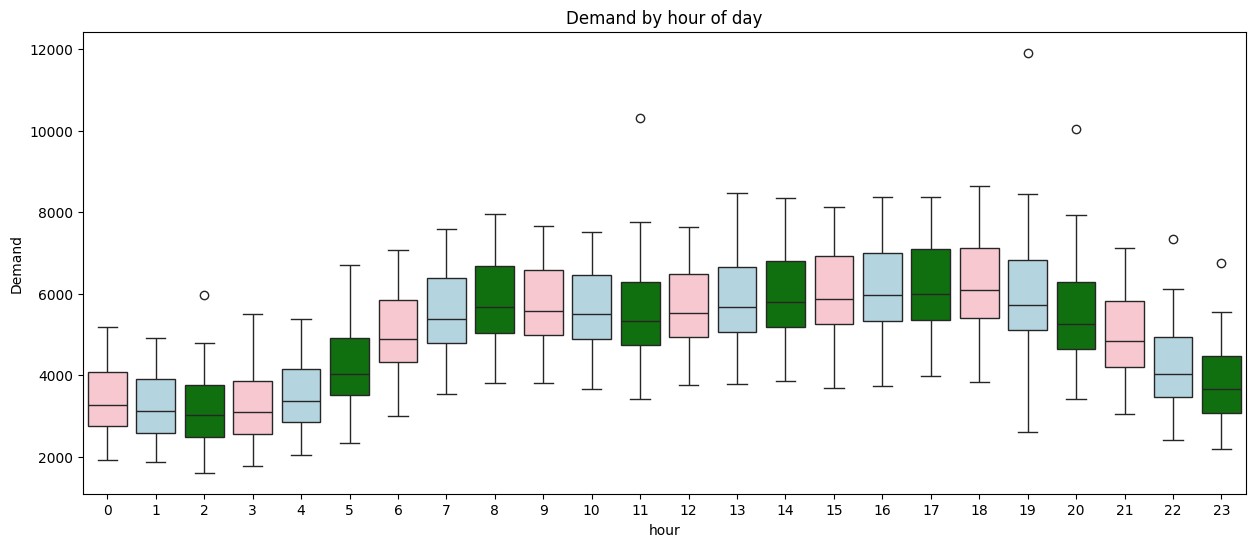

In [185]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df, x='hour',y='Demand',palette=['pink','lightblue','green']*8)
plt.title('Demand by hour of day')
plt.show()

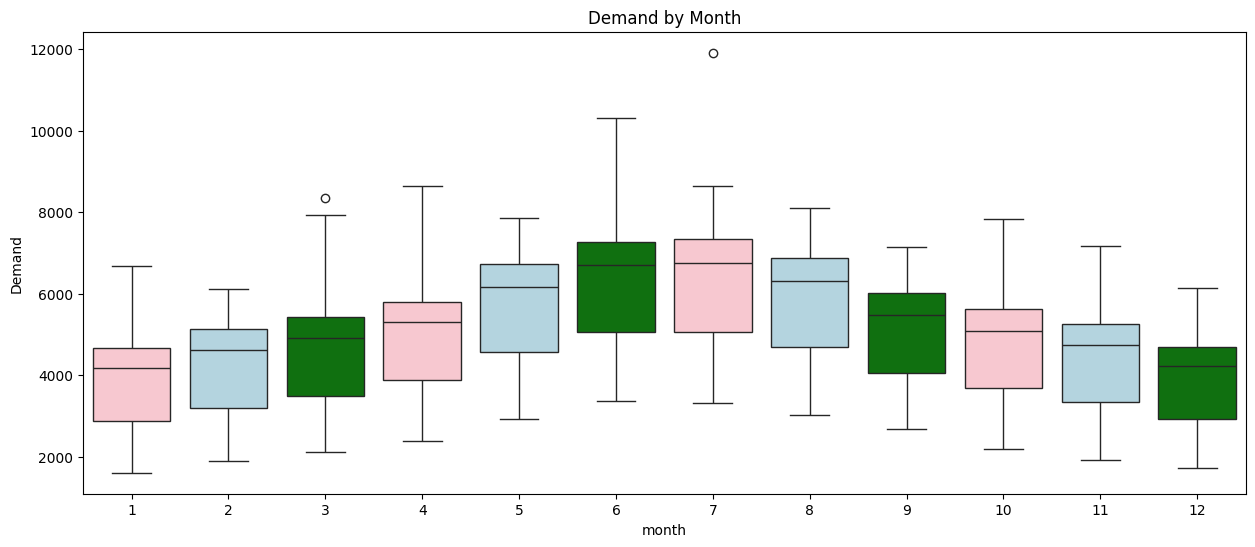

In [186]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df,x='month',y='Demand',palette=['pink','lightblue','green']*4)
plt.title('Demand by Month')
plt.show()

* as we can see the highest demand of electricity is in the month of june.

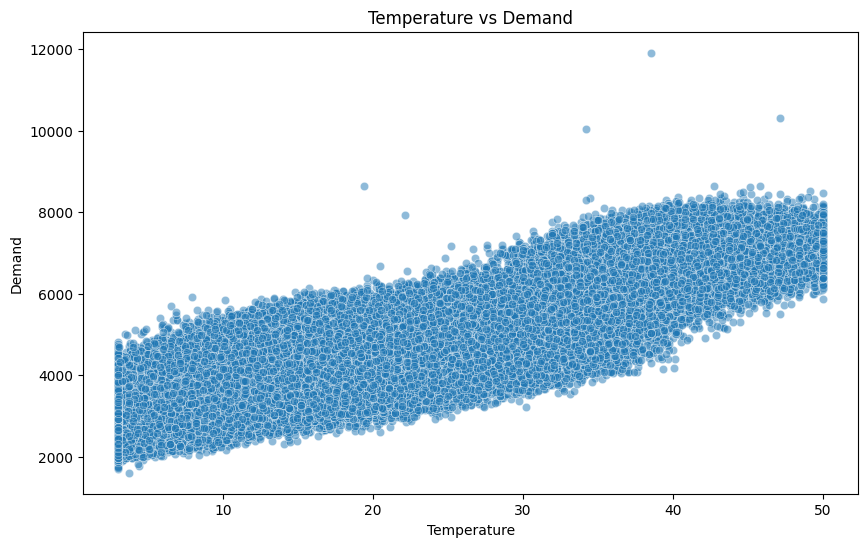

In [187]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df,x='Temperature',y='Demand',alpha=0.5)
plt.title('Temperature vs Demand')
plt.show()

* as the temperature increases the demand will also increase

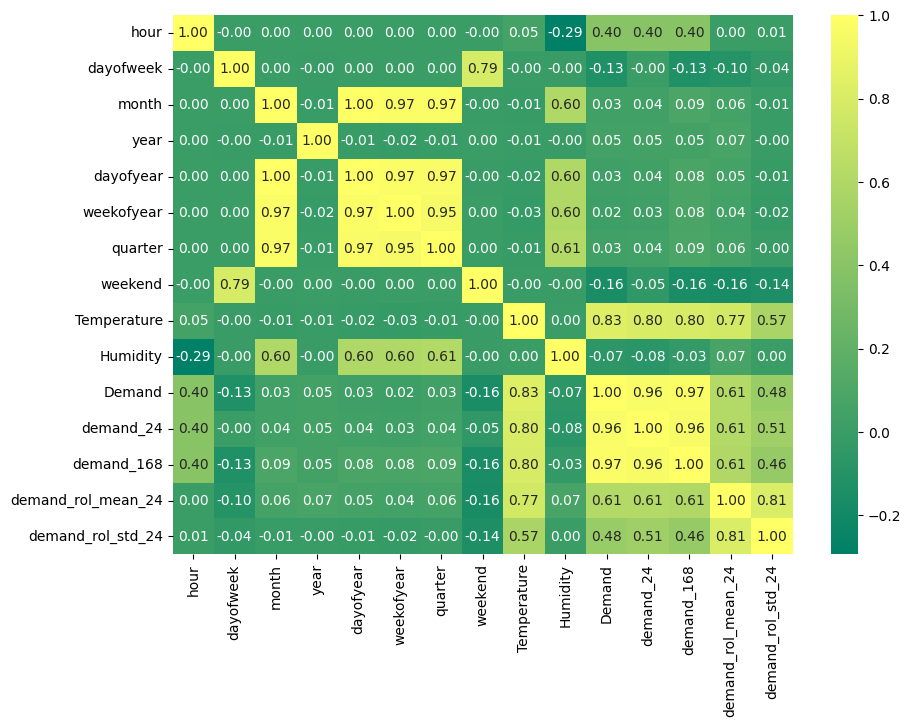

In [188]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,cmap='summer',fmt='.2f')
plt.show()

the lagged features we created have a very high correlation with demand and rolling mean and std also have positive correlation

In [189]:
# spilit the data into X feature and Y target
X = df.drop('Demand',axis=1)
Y = df['Demand']

In [190]:
X_train = X.loc[:'2023-12-31']    # 80% of data for X_train
Y_train = Y.loc[:'2023-12-31']

In [191]:
X_test = X.loc['2024-01-01' :]   # 20% of data for X_test
Y_test = Y.loc['2024-01-01' :]

In [192]:
X.shape, X_train.shape, X_test.shape

((43676, 14), (34892, 14), (8784, 14))

**XGBoost**


XGBoost is a powerfull algorithim for time series forecasting as it can handel non linear data easily.


It can handel seasonality and trends in time series data effectively.

In [193]:
from xgboost import XGBRegressor

# initialize the model
model_xg = XGBRegressor(n_estimators=1000,
                        early_stopping_rounds=50,
                        learning_rate=0.01,
                        random_staate=42,
                        Objective='reg:squarederror')

In [194]:
model_xg.fit(X_train, Y_train, eval_set=[(X_train, Y_train),(X_test, Y_test)], verbose= False)

XGBRegressor(Objective='reg:squarederror', base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [195]:
pred_xg = model_xg.predict(X_test)

rmse_xg = np.sqrt(mean_squared_error(Y_test,pred_xg))
mae_xg = mean_absolute_error(Y_test, pred_xg)
r2_xg = r2_score(Y_test, pred_xg)
print(f'RMSE: {rmse_xg}')
print(f'MAE: {mae_xg}')
print(f'r2_score: {r2_xg}')

RMSE: 175.22716387271916
MAE: 123.47612356015286
r2_score: 0.9846208346617227


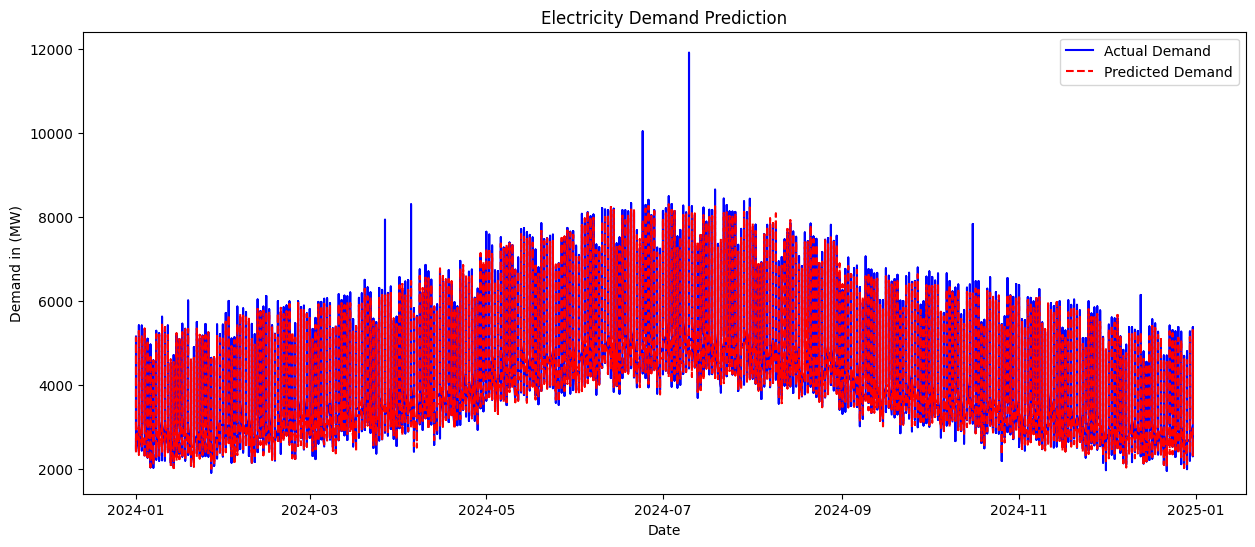

In [196]:
plt.figure(figsize=(15,6))
plt.plot(Y_test.index, Y_test, label='Actual Demand',color='Blue')
plt.plot(Y_test.index, pred_xg, label='Predicted Demand',color='red',linestyle='--')
plt.title('Electricity Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand in (MW)')
plt.legend()
plt.show()